# Linear Unit with Synthetic Data
This notebook showcases the usage of the LinearUnit using synthetic data.

In [1]:
import os
import random

import dotenv
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection._split import train_test_split

_ = dotenv.load_dotenv()

from app.loggers import get_logger
from app.models import LinearUnit
from app.models import Matrix

logger = get_logger(__name__)

In [2]:
def generate_data():
    """Generate synthetic data"""
    data_x = list(range(-100, 100))
    data_x = [[xi] for xi in data_x]
    w_truth = Matrix(matrix=[[2]])
    b_truth = Matrix(matrix=[[5]])

    # Generate ideal data from a linear function
    x_ideal = Matrix(matrix=[xi for xi in data_x])
    y_ideal = x_ideal * w_truth + b_truth
    logger.debug("y_truth=\n[%s]\n", y_ideal)

    # Add noise to the ideal data to make it more realistic.
    # How much noise we want (0 no noise, 1x noise, 2x, etc.)
    desired_sigma_for_x = 2
    desired_sigma_for_y = 20
    # Gausian noise to simulate real data (standard/normal distribution)
    x_noise = Matrix(rows=x_ideal.rows, cols=x_ideal.cols)
    x_noise.populate(lambda: random.normalvariate(0, 1))
    x_noise = x_noise * desired_sigma_for_x

    y_noise = Matrix(rows=y_ideal.rows, cols=y_ideal.cols)
    y_noise.populate(lambda: random.normalvariate(0, 1))
    y_noise = y_noise * desired_sigma_for_y

    # real values would be ideal + noise
    x_real = x_ideal + x_noise
    y_real = y_ideal + y_noise
    logger.debug(
        "data=\n[%s]\n",
        [(x_real.matrix[i][0], y_real.matrix[i][0]) for i in range(x_real.rows)],
    )

    data_x = [xi for xi in x_real.matrix]
    data_y = [yi for yi in y_real.matrix]
    return data_x, data_y

## Data and Parameters

In [3]:
data_x, data_y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)
learning_rate = 0.000001
epochs = 100
batch_size = 16

## Training

In [4]:
linear_unit = LinearUnit(X_train, y_train)
linear_unit.train(learning_rate, epochs, batch_size)
logger.info("w_current=[%s]", linear_unit.w_current)
logger.info("b_current=[%s]", linear_unit.b_current)
logger.info("latest_loss=%s", linear_unit.batch_loss_scores[-1])

2025-12-20 21:32:50,377 - deep_learning.__main__ - INFO - w_current=[2.024676654086029] (2438074692.py:3)
2025-12-20 21:32:50,377 - deep_learning.__main__ - INFO - b_current=[-0.10081773470898016] (2438074692.py:4)
2025-12-20 21:32:50,378 - deep_learning.__main__ - INFO - latest_loss=325.5696610641427 (2438074692.py:5)


## Results

In [8]:
lu_preds = linear_unit.infer(X_test).flatten()
lu_score = r2_score(y_test, lu_preds)
logger.info("Linear Unit Score(r2): %s", lu_score)

2025-12-20 21:35:28,013 - deep_learning.__main__ - INFO - Linear Unit Score(r2): 0.9711140274071273 (1410942036.py:3)


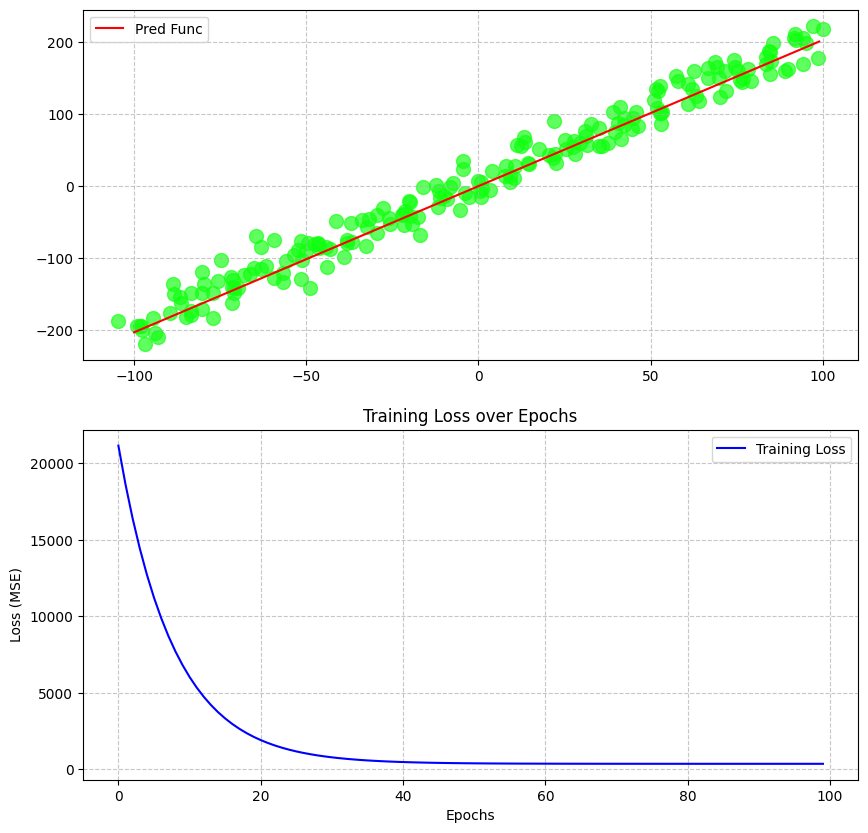

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
real_pt = fig.add_subplot(gs[0, :])
pred_func_x = list(range(-100, 100))
pred_func_y = linear_unit.infer([[xi] for xi in pred_func_x]).flatten()
real_pt.plot(pred_func_x, pred_func_y, label="Pred Func", color="red")
real_pt.scatter(sum(data_x, []), sum(data_y, []), color="#11ff11aa", s=100)
real_pt.grid(True, linestyle="--", alpha=0.7)
real_pt.legend()

loss_pt = fig.add_subplot(gs[1, :])
loss_pt.plot(linear_unit.epoch_loss_scores, label="Training Loss", color="blue")
loss_pt.set_title("Training Loss over Epochs")
loss_pt.set_xlabel("Epochs")
loss_pt.set_ylabel("Loss (MSE)")
loss_pt.grid(True, linestyle="--", alpha=0.7)
loss_pt.legend()

plt.show()